In [ ]:
from keras.datasets import cifar10, mnist
import numpy as np
import tensorflow as tf
import random
from keras.models import load_model
import os
import keras
from keras.callbacks import Callback
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Done loading data")

Done loading data


In [ ]:
taskA_indx_train = np.where((y_train==0)|(y_train==1)|(y_train==2)|(y_train==3)|(y_train==4))[0]
taskA_indx_test = np.where((y_test==0)|(y_test==1)|(y_test==2)|(y_test==3)|(y_test==4))[0]

taskB_indx_train = np.setdiff1d(np.arange(y_train.shape[0]), taskA_indx_train)
taskB_indx_test = np.setdiff1d(np.arange(y_test.shape[0]), taskA_indx_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 10

model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same',
#                  input_shape=(28,28,1)))
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128,(3,3),padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3),padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
model.add(Dense(512, input_shape=(28*28,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
num_classes = 10
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
# class MultitaskCallback(Callback):
  
#   def __init__(self, main_task, previous_task=None):
#     self.main_task_preds=[]
#     self.previous_task_preds=[]
#     self.main_task = main_task
#     self.previous_task = previous_task

#   def on_epoch_end(self, epoch, logs=None):
#     x,y = self.main_task
#     predsA = self.model.evaluate(x,y)[1]
#     print(f"Evaluation results Main {predsA}")
#     self.main_task_preds.append(1-predsA)
    
#     if self.previous_task:
#       x2,y2 = self.previous_task
#       predsB = self.model.evaluate(x2, y2)[1]
#       print(f"Evaluation results Previous {predsB}")
#       self.previous_task_preds.append(1-predsB)

class MultitaskCallback(Callback):
  
  def __init__(self, main_task, previous_task=None):
    self.main_task = main_task
    self.previous_task = previous_task
    self.main_task_preds=[]
    self.previous_task_preds=[]
    self.batch_counter = 0

  def on_train_batch_end(self, batch, logs=None):
    if self.batch_counter %25 == 0:
      x,y = self.main_task
      predsA = self.model.evaluate(x,y)[1]
      print(f"Evaluation results Main {predsA}")
      self.main_task_preds.append(1-predsA)
      
      if self.previous_task:
        x2,y2 = self.previous_task
        predsB = self.model.evaluate(x2, y2)[1]
        print(f"Evaluation results Previous {predsB}")
        self.previous_task_preds.append(1-predsB)
    self.batch_counter +=1
    

In [ ]:
# tensorboard = keras.callbacks.TensorBoard('/content/drive/My Drive/forgetting/taskA')
# print(taskA_indx_train)
taskA_callback = MultitaskCallback((x_test[taskA_indx_test], y_test[taskA_indx_test]))
model.fit(x_train[taskA_indx_train], 
          y_train[taskA_indx_train],
          callbacks=[taskA_callback],
          batch_size=128,
          epochs=5,
          validation_data=(x_test[taskA_indx_test],y_test[taskA_indx_test])
          )


In [ ]:
# tensorboardB = keras.callbacks.TensorBoard('/content/drive/My Drive/forgetting/taskB')
taskB_callback = MultitaskCallback((x_test[taskB_indx_test], y_test[taskB_indx_test]),
                                   (x_test[taskA_indx_test], y_test[taskA_indx_test]))
model.fit(x_train[taskB_indx_train], 
          y_train[taskB_indx_train],
          callbacks=[taskB_callback],
          batch_size=128,
          epochs=10,
          validation_data=(x_test[taskB_indx_test], y_test[taskB_indx_test])
          )

In [ ]:
print(len(taskB_callback.main_task_preds))
print(len(taskB_callback.previous_task_preds))
print(len(taskA_callback.main_task_preds))

print(taskA_callback.main_task_preds)
print(taskB_callback.main_task_preds)
print(taskB_callback.previous_task_preds)

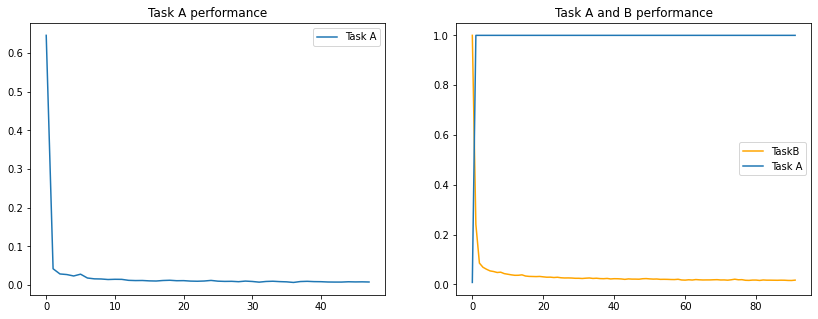

In [ ]:
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.set_title("Task A performance")
ax1.plot(taskA_callback.main_task_preds, label='Task A')
ax1.legend()
ax2.set_title("Task A and B performance")
ax2.plot(taskB_callback.main_task_preds, 'orange',label="TaskB")
ax2.plot(taskB_callback.previous_task_preds,label='Task A')
ax2.legend()
plt.show()
fig.savefig('/content/drive/My Drive/hw3_1a.png')

In [ ]:
a = np.arange(50000)
b = np.setdiff1d(a,taskA_indx_train[0])
print(b)
u = np.intersect1d(b,taskA_indx_train[0])
print(u)
print(y_train.shape[0])


[    0     2     3 ... 49997 49998 49999]
[]
60000


In [ ]:
a = np.random.randint(0,5,(10,6))
print(a)
ix =[1,3,5,7,9]
print(a[ix][:, :3])

[[2 2 0 4 4 4]
 [1 1 0 2 0 2]
 [3 0 0 4 3 3]
 [4 2 1 2 0 0]
 [1 1 1 0 2 2]
 [2 3 1 3 4 4]
 [3 4 1 1 2 0]
 [0 1 4 0 4 3]
 [2 2 0 1 4 2]
 [0 2 0 0 3 4]]
[[1 1 0]
 [4 2 1]
 [2 3 1]
 [0 1 4]
 [0 2 0]]
